In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv


# **Image classification with sign langauage MNIST using pytorch**
This is a part of course project conducted by jovian.ml with freecodecamp. In this project,I have used sign langauage MNIST dataset to predict sign language images using diffrent modals like loginstic regression, feed forword nn, convolution nn.

In [2]:
project_name = 'final-project-jovain.ml'

# sign language MNIST dataset


The American Sign Language letter database of hand gestures represent a multi-class problem with 24 classes of letters (excluding J and Z which require motion).

The dataset format is patterned to match closely with the classic MNIST. Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions). The training data (27,455 cases) and test data (7172 cases) are approximately half the size of the standard MNIST but otherwise similar with a header row of label, pixel1,pixel2….pixel784 which represent a single 28x28 pixel image with grayscale values between 0-255. The original hand gesture image data represented multiple users repeating the gesture against different backgrounds. The Sign Language MNIST data came from greatly extending the small number (1704) of the color images included as not cropped around the hand region of interest. 

# Downloading and exploring the data 

first, I will import some libraries that i will throughout this project

In [3]:
! pip install jovian --upgrade -q

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

from PIL import Image
import pandas as pd

from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid

import jovian

<IPython.core.display.Javascript object>

In [5]:
data_dir = "../input/sign-language-mnist/"

In [6]:
test_df = pd.read_csv(data_dir+'sign_mnist_test/sign_mnist_test.csv')
train_df = pd.read_csv(data_dir+'sign_mnist_train/sign_mnist_train.csv')

Let's look some of the data rows from train_df.

In [7]:
train_df.head(10)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


In [35]:
Classes = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
Classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

Now, I have created a helper function to convert all dataframes into numpy array

In [8]:
def dataframe_to_nparray(train_df, test_df):
    train_df1 = train_df.copy(deep = True)
    test_df1 = test_df.copy(deep = True)
    train_images = train_df1.iloc[:, 1:].to_numpy(dtype = 'float32')
    test_images = test_df1.iloc[:, 1:].to_numpy(dtype = 'float32')
    return train_images,test_images

In [9]:
train_img, test_img = dataframe_to_nparray(train_df, test_df)
train_labels = train_df['label'].values
test_labels = test_df['label'].values

In [10]:
train_img.size

21524720

In [11]:
train_images_shaped = train_img.reshape(train_img.shape[0],1,28,28)
test_images_shaped = test_img.reshape(test_img.shape[0],1,28,28)

Next step is to convert all numpy arrays into pytorch tensors

In [12]:
train_images_tensors = torch.from_numpy(train_images_shaped)
train_labels_tensors = torch.from_numpy(train_labels)

test_images_tensors = torch.from_numpy(test_images_shaped)
test_labels_tensors = torch.from_numpy(test_labels)

In [13]:
# pytorch dataset
train_ds_full = TensorDataset(train_images_tensors, train_labels_tensors) #this dataset will further devided into validation dataset and training dataset
test_ds = TensorDataset(test_images_tensors, test_labels_tensors)

We can see that we converted each image in a 3-dimensions tensor (1, 28, 28). The first dimension is for the number of channels. The second and third dimensions are for the size of the image, in this case, 28px by 28px.

In [14]:
img, label = train_ds_full[0]
print(img.shape, label)
img

torch.Size([1, 28, 28]) tensor(3)


tensor([[[107., 118., 127., 134., 139., 143., 146., 150., 153., 156., 158.,
          160., 163., 165., 159., 166., 168., 170., 170., 171., 171., 171.,
          172., 171., 171., 170., 170., 169.],
         [111., 121., 129., 135., 141., 144., 148., 151., 154., 157., 160.,
          163., 164., 170., 119., 152., 171., 171., 170., 171., 172., 172.,
          172., 172., 172., 171., 171., 170.],
         [113., 123., 131., 137., 142., 145., 150., 152., 155., 158., 161.,
          163., 164., 172., 105., 142., 170., 171., 171., 171., 172., 172.,
          173., 173., 172., 171., 171., 171.],
         [116., 125., 133., 139., 143., 146., 151., 153., 156., 159., 162.,
          163., 167., 167.,  95., 144., 171., 172., 172., 172., 172., 172.,
          173., 173., 173., 172., 172., 171.],
         [117., 126., 134., 140., 145., 149., 153., 156., 158., 161., 163.,
          164., 175., 156.,  87., 154., 172., 173., 173., 173., 173., 173.,
          174., 174., 174., 173., 172., 172.],
     

Now we will define hyperparameters for our modal

In [15]:
# Hyperparmeters
batch_size = 64
learning_rate = 0.001

# Other constants
in_channels = 1
input_size = in_channels * 28 * 28
num_classes = 26


# Training and validation dataset 
Now we are going to use three datasets-
<ol>
<li>Training set - used to train the model (compute the loss and adjust the weights of the model using gradient descent).</li>
<li>Validation set - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.</li>
<li>Test set - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.</li>
    </ol>

In [16]:
random_seed = 11
torch.manual_seed(random_seed);

In [17]:
val_size = 7455
train_size = len(train_ds_full) - val_size

train_ds, val_ds = random_split(train_ds_full, [train_size, val_size,])
len(train_ds), len(val_ds), len(test_ds)

(20000, 7455, 7172)

let's look some of the sign language images form train dataset

In [39]:
def show_image(image, label):
    print("Alphabet: ", Classes[label.item()])
    plt.imshow(image.view(28,28))

Alphabet:  M


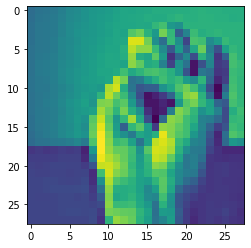

In [40]:
show_image(*train_ds[8])

Alphabet:  E


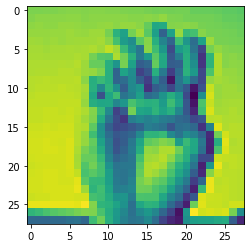

In [41]:
show_image(*train_ds[6363])

Now we will load the training,validation and test dataset in batches 

In [42]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

In [43]:
for img, label in train_dl:
    print(img.size())
    break

torch.Size([64, 1, 28, 28])


# Models for image classification
We are going to create three different models for this project:

1. Logistic Regression
1. Deep Neural Network
1. Convolutional Neural Network


# Logistic regression

In [44]:
class ASLModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, in_channels*28*28)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = ASLModel()

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [48]:
for images, labels in test_dl:
    outputs = model(images)
    print(labels)
    print(accuracy(outputs, labels))
    
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

tensor([ 6,  5, 10,  0,  3, 21, 10, 14,  3,  7,  8,  8, 21, 12,  7,  4, 22,  0,
         7,  7,  2,  0, 21,  4, 10, 15,  2, 15,  7,  1,  7,  8, 13, 19,  3, 21,
        13,  3, 18, 14, 15, 23,  8, 15, 14,  5, 17,  4, 19, 13, 20, 22, 20,  5,
        16, 16, 21,  4,  7, 22, 10, 13, 11, 22,  2, 10,  1,  4, 18,  4, 20,  6,
        15,  4,  3, 20, 15, 11,  2,  2, 17,  2,  7, 21, 23,  7, 12, 17, 24, 14,
         2,  1,  7, 23,  8,  5,  0,  0, 19, 21,  8,  4,  2, 20, 16,  1, 15, 14,
         2,  6, 12,  5,  0, 24,  2, 19, 14, 24, 16, 10,  4,  8,  8, 12, 12,  8,
         6, 21])
tensor(0.0469)
outputs.shape :  torch.Size([128, 26])
Sample outputs :
 tensor([[ 211.0894,    3.9080,   30.5896,   17.1906,  -15.0909,   19.7029,
          -48.1107,  117.7160, -146.4884,  -38.2365,  141.9215,    3.2207,
          138.7958,  -76.7088,  113.8116,   71.1790,    8.3353,  104.8763,
           40.8407, -100.3698,   16.3320,   44.1973,  -26.7148,   17.2877,
          -43.4955,  -10.4784],
        [ 215.0013,

In [49]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [50]:
result0 = evaluate(model, val_dl)
result0

{'val_loss': 238.73550415039062, 'val_acc': 0.03790493309497833}

The initial accuracy is around 4%, which is what one might expect from a randomly intialized model (since it has a 4 in 100 chance of getting a label right by guessing randomly). Also note that we are using the .format method with the message string to print only the first four digits after the decimal point.

We are now ready to train the model. Let's train for 20 epochs and look at the results.

In [51]:
history1 = fit(10, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 3231.4958, val_acc: 0.2478
Epoch [1], val_loss: 1426.5219, val_acc: 0.3704
Epoch [2], val_loss: 1337.9803, val_acc: 0.3728
Epoch [3], val_loss: 972.9146, val_acc: 0.4799
Epoch [4], val_loss: 468.5796, val_acc: 0.5805
Epoch [5], val_loss: 802.1404, val_acc: 0.4353
Epoch [6], val_loss: 510.2693, val_acc: 0.5390
Epoch [7], val_loss: 104.5550, val_acc: 0.7977
Epoch [8], val_loss: 625.7599, val_acc: 0.4293
Epoch [9], val_loss: 172.1978, val_acc: 0.6934


In [52]:
history2 = fit(10, 0.0001, model, train_dl, val_dl)

Epoch [0], val_loss: 24.7471, val_acc: 0.9090
Epoch [1], val_loss: 23.3023, val_acc: 0.9115
Epoch [2], val_loss: 22.1002, val_acc: 0.9106
Epoch [3], val_loss: 20.5681, val_acc: 0.9114
Epoch [4], val_loss: 19.3864, val_acc: 0.9199
Epoch [5], val_loss: 18.2754, val_acc: 0.9111
Epoch [6], val_loss: 18.1149, val_acc: 0.9158
Epoch [7], val_loss: 16.9470, val_acc: 0.9172
Epoch [8], val_loss: 13.8040, val_acc: 0.9285
Epoch [9], val_loss: 13.4496, val_acc: 0.9324


Now with 40 iteration we went from 4% acc to 94% accuracy.It's quite amazing

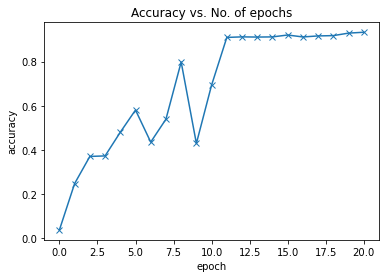

In [53]:
history = [result0] + history1 + history2
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

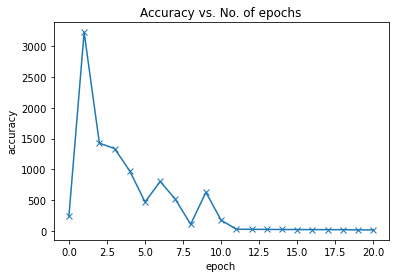

In [55]:
history = [result0] + history1 + history2 
accuracies = [result['val_loss'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [56]:
# evaluate on test dataset
result = evaluate(model, test_dl)
result

{'val_loss': 175.28811645507812, 'val_acc': 0.6677631735801697}

# Prediction

In [57]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: I , Predicted: I


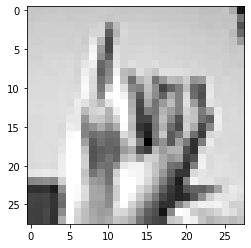

In [59]:
img, label = test_ds[10]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', Classes[label.item()], ', Predicted:', Classes[predict_image(img, model)])

Label: H , Predicted: H


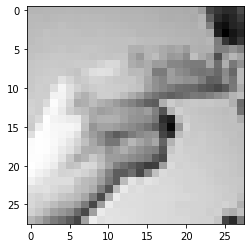

In [61]:
img, label = test_ds[200]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', Classes[label.item()], ', Predicted:', Classes[predict_image(img, model)])

Label: D , Predicted: D


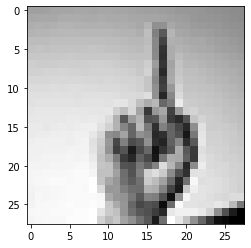

In [62]:
img, label = test_ds[1000]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', Classes[label.item()], ', Predicted:', Classes[predict_image(img, model)])

# saving the modal

In [63]:
torch.save(model.state_dict(), 'ASL-logistic.pth')

# Commit and upload the notebook
As a final step, we can save and commit our work using the jovian library. Along with the notebook, we can also attach the weights of our trained model, so that we can use it later.

In [64]:
jovian.commit(project= project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sachinsom507/final-project-jovain.ml


<IPython.core.display.Javascript object>

# Deep Neural Network

## Definging the model

In [19]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [159]:
class ASLModel2(nn.Module):
    """Feedfoward neural network with 2 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer 1
        self.linear1 = nn.Linear(in_size, 512)
        # hidden layer 2
        self.linear2 = nn.Linear(512, 256)
        # hidden layer 3
        self.linear3 = nn.Linear(256, 128)
        # output layer  
        self.linear4 = nn.Linear(128, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        out = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer 1
        out = self.linear1(out)
        # Apply activation function
        out = F.relu(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = F.relu(out)
        # Get inermediate outputs using hidden layer 3
        out = self.linear3(out)
        # Apply a activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

# Using a GPU 
To work with GPU's we have to take help of some utility functions, so let's define couple utility functions 

In [160]:
torch.cuda.is_available()

True

In [161]:
def get_default_device():
    if torch.cuda.is_available() == True:
        return torch.device('cuda')
    else: 
        return torch.device('cpu')

In [162]:
device = get_default_device()
device

device(type='cuda')

In [163]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [164]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [165]:
print(train_dl.device)
print(test_dl.device)
print(val_dl.device)

cuda
cuda
cuda


# Training the Modal

In [166]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [167]:
input_size, num_classes

(784, 26)

In [168]:
model = ASLModel2(input_size, out_size = num_classes)

In [169]:
# for loading our model into GPU
model = to_device(model, device)

In [170]:
model

ASLModel2(
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=26, bias=True)
)

In [171]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 14.12060546875, 'val_acc': 0.041877392679452896}]

so initially, this modal has very small accuracy of almost 3% that is vary low.
so to improve this, we will iterate the process upto some epochs

In [172]:
history += fit(10, .001, model, train_dl, val_dl)

Epoch [0], val_loss: 1.9782, val_acc: 0.3867
Epoch [1], val_loss: 1.3152, val_acc: 0.5732
Epoch [2], val_loss: 1.0640, val_acc: 0.6374
Epoch [3], val_loss: 0.8769, val_acc: 0.6941
Epoch [4], val_loss: 0.6305, val_acc: 0.7931
Epoch [5], val_loss: 0.5267, val_acc: 0.8190
Epoch [6], val_loss: 0.3588, val_acc: 0.8940
Epoch [7], val_loss: 0.1764, val_acc: 0.9652
Epoch [8], val_loss: 0.2343, val_acc: 0.9314
Epoch [9], val_loss: 0.1089, val_acc: 0.9845


In [173]:
history

[{'val_loss': 14.12060546875, 'val_acc': 0.041877392679452896},
 {'val_loss': 1.9781674146652222, 'val_acc': 0.38665682077407837},
 {'val_loss': 1.31515634059906, 'val_acc': 0.573153018951416},
 {'val_loss': 1.0640181303024292, 'val_acc': 0.6374085545539856},
 {'val_loss': 0.8769174218177795, 'val_acc': 0.6940823197364807},
 {'val_loss': 0.630497395992279, 'val_acc': 0.7930819392204285},
 {'val_loss': 0.5266682505607605, 'val_acc': 0.8189541697502136},
 {'val_loss': 0.3587874174118042, 'val_acc': 0.8940165042877197},
 {'val_loss': 0.1763860136270523, 'val_acc': 0.9651747941970825},
 {'val_loss': 0.2342948168516159, 'val_acc': 0.9313918352127075},
 {'val_loss': 0.10888687521219254, 'val_acc': 0.9844903349876404}]

Text(0.5, 1.0, 'epoch vs loss')

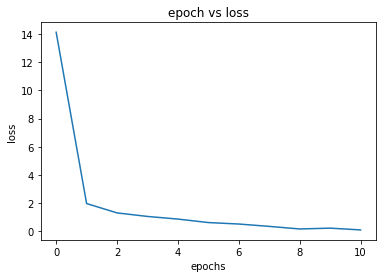

In [182]:
losses = [x['val_loss'] for x in history]
plt.plot(losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('epoch vs loss')

Text(0.5, 1.0, 'epoch vs accuracy')

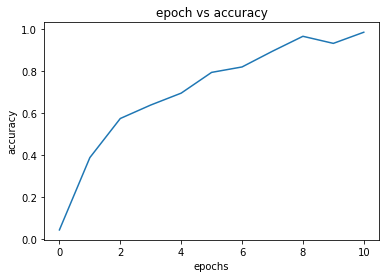

In [184]:
acc = [x['val_acc'] for x in history]
plt.plot(acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('epoch vs accuracy')

In [185]:
result = evaluate(model, test_dl)

In [186]:
result

{'val_loss': 0.8095934987068176, 'val_acc': 0.7504112124443054}

# predictions

In [191]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 18 , Predicted: 18


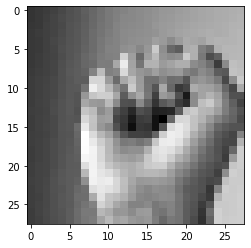

In [192]:
img, label = test_ds[229]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(img, model))

Label: 21 , Predicted: 10


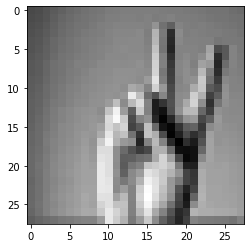

In [193]:
img, label = test_ds[6767]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


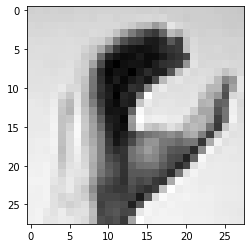

In [196]:
img, label = test_ds[7171]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(img, model))

Label: 10 , Predicted: 24


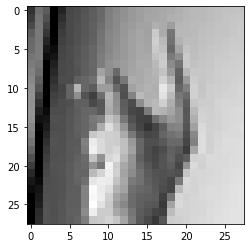

In [197]:
img, label = test_ds[6762]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(img, model))

Label: 16 , Predicted: 16


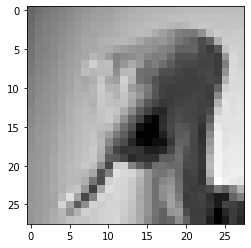

In [198]:
img, label = test_ds[55]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(img, model))

Label: 1 , Predicted: 1


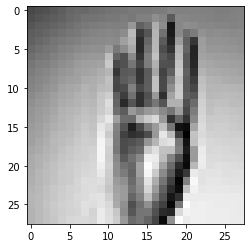

In [199]:
img, label = test_ds[6766]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label.item(), ', Predicted:', predict_image(img, model))

# saving the Model

In [201]:
torch.save(model.state_dict(), 'ASL-dnn.pth')

# commiting the notebook 

In [ ]:
jovian.commit(project=project_name, enviornment=True)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sachinsom507/final-project-jovain.ml


<IPython.core.display.Javascript object>

# Convolution Neural Network

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ASLBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [26]:
class ASLCNNModel(ASLBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels, 28, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(28, 28, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),     #image size : 28*14*14 

            nn.Conv2d(28, 56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(56, 56, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # image size : 56*7*7

            nn.Flatten(), 
            nn.Linear(56*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))
        
    def forward(self, xb):
        return self.network(xb)

In [27]:
in_channels, num_classes

(1, 26)

In [28]:
model = ASLCNNModel(in_channels, num_classes)
model

ASLCNNModel(
  (network): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten()
    (11): Linear(in_features=2744, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=128, bias=True)
    (14): ReLU()
    (15): Linear(in_features=128, out_features=26, bias=True)
  )
)

In [29]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [30]:
device = get_default_device()
device

device(type='cuda')

In [31]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
to_device(model, device);

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [35]:
model = to_device(ASLCNNModel(in_channels, num_classes), device)

In [36]:
evaluate(model, val_dl)

{'val_loss': 3.2676336765289307, 'val_acc': 0.04229172319173813}

so, initially this cnn model gives us 4% accuracy and a large validation loss of 3.26

In [37]:
num_epochs = 10
opt_func = torch.optim.Adam

In [38]:
history = fit(num_epochs, 0.001 , model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.8871, val_loss: 0.0532, val_acc: 0.9804
Epoch [1], train_loss: 0.0219, val_loss: 0.0454, val_acc: 0.9852
Epoch [2], train_loss: 0.0154, val_loss: 0.0004, val_acc: 1.0000
Epoch [3], train_loss: 0.0001, val_loss: 0.0001, val_acc: 1.0000
Epoch [4], train_loss: 0.0000, val_loss: 0.0001, val_acc: 1.0000
Epoch [5], train_loss: 0.0000, val_loss: 0.0001, val_acc: 1.0000
Epoch [6], train_loss: 0.0000, val_loss: 0.0001, val_acc: 1.0000
Epoch [7], train_loss: 0.0000, val_loss: 0.0001, val_acc: 1.0000
Epoch [8], train_loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000
Epoch [9], train_loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000


In [39]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

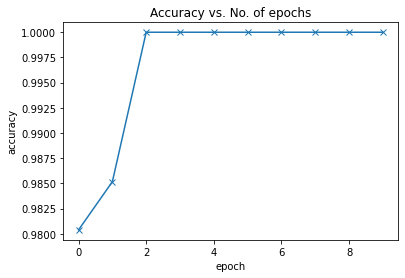

In [40]:
plot_accuracies(history)

In [41]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


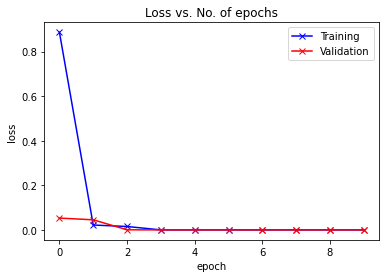

In [42]:
plot_losses(history)

# Testing With Test Images

In [53]:
# Testing with test dataloader
result = evaluate(model, test_dl)
result

{'val_loss': 0.36439788341522217, 'val_acc': 0.9439418911933899}

In [43]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

Label: tensor(6) , Predicted: 6


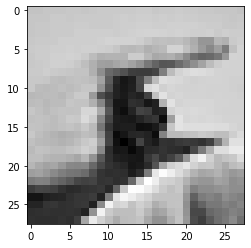

In [50]:
img, label = test_ds[0]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: tensor(10) , Predicted: 10


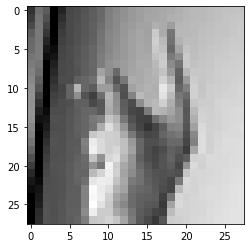

In [51]:
img, label = test_ds[6762]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: tensor(17) , Predicted: 17


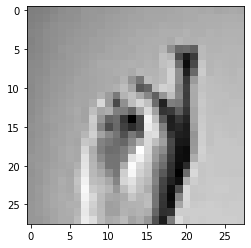

In [54]:
img, label = test_ds[3535]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: tensor(4) , Predicted: 4


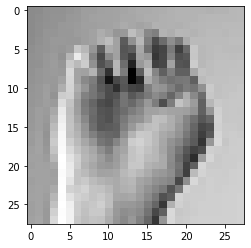

In [57]:
img, label = test_ds[23]
plt.imshow(img.view(28,28), cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

# Saving the model


In [60]:
torch.save(model.state_dict(), '3-asl-cnn.pth')

# Commiting the notebook in jovianML

In [61]:
jovian.commit(project= project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sachinsom507/final-project-jovain.ml


<IPython.core.display.Javascript object>